# Supply Chain Analytics

### Introduction
The project involves understanding what is needed, setting goals and business objectives, creating the technical foundation, exploring and analyzing data, and using machine learning to predict and group things.

In [50]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# Set options for displaying dataframes and figures
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import seaborn as sns
import folium
from folium import plugins
from matplotlib.ticker import PercentFormatter
from IPython.display import Image
Image("ABC.png")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from folium import plugins

Download data from https://data.mendeley.com/datasets/8gx2fvg2k6/5

Analysis with the help of https://medium.com/@lukas.niederhaeuser_1037/supply-chain-analytics-part-1-business-understanding-and-technical-setup-c7a7cfe1834d and https://github.com/LukasNiederhaeuser/Supply_Chain_Clustering_Forecasting

## --------------------------------------------Clustering--------------------------------------------

In [11]:
# Import data
df = pd.read_csv('/Users/moni/DS - Karan/Week5/Data-2/DataCoSupplyChainDataset.csv', sep=",", encoding = "latin-1")
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


About the data: The underlying data is transactional data, where each item is attributed to a customer and an order. An order can consist of multiple SKUs. This is important information when filtering and analyzing the data

## Data cleaning and pre-processing

In [12]:
# Check the shape of the data
df.shape

(180519, 53)

In [13]:
# Get a description of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

The column “Product Description” seems to include no data and can therefore be deleted.

Although these columns “Customer Lname”, “Customer Zipcode” and “Order Zipcode” include missing values but Since they are not needed for our use case, we can delete these columns. Further, the columns “Customer Email” and “Customer Password” can be deleted as well.

In [14]:
# Drop unnecessary columns, containing missing data
df.drop(columns=["Product Description", "Customer Lname",
                      "Customer Zipcode", "Order Zipcode",
                      "Customer Email", "Customer Password", 
                      "Product Image"],
                      inplace = True)

# Change the date-columns to the appropriate format
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"]).dt.date
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"]).dt.date

## Exploratory Data Analysis (EDA)

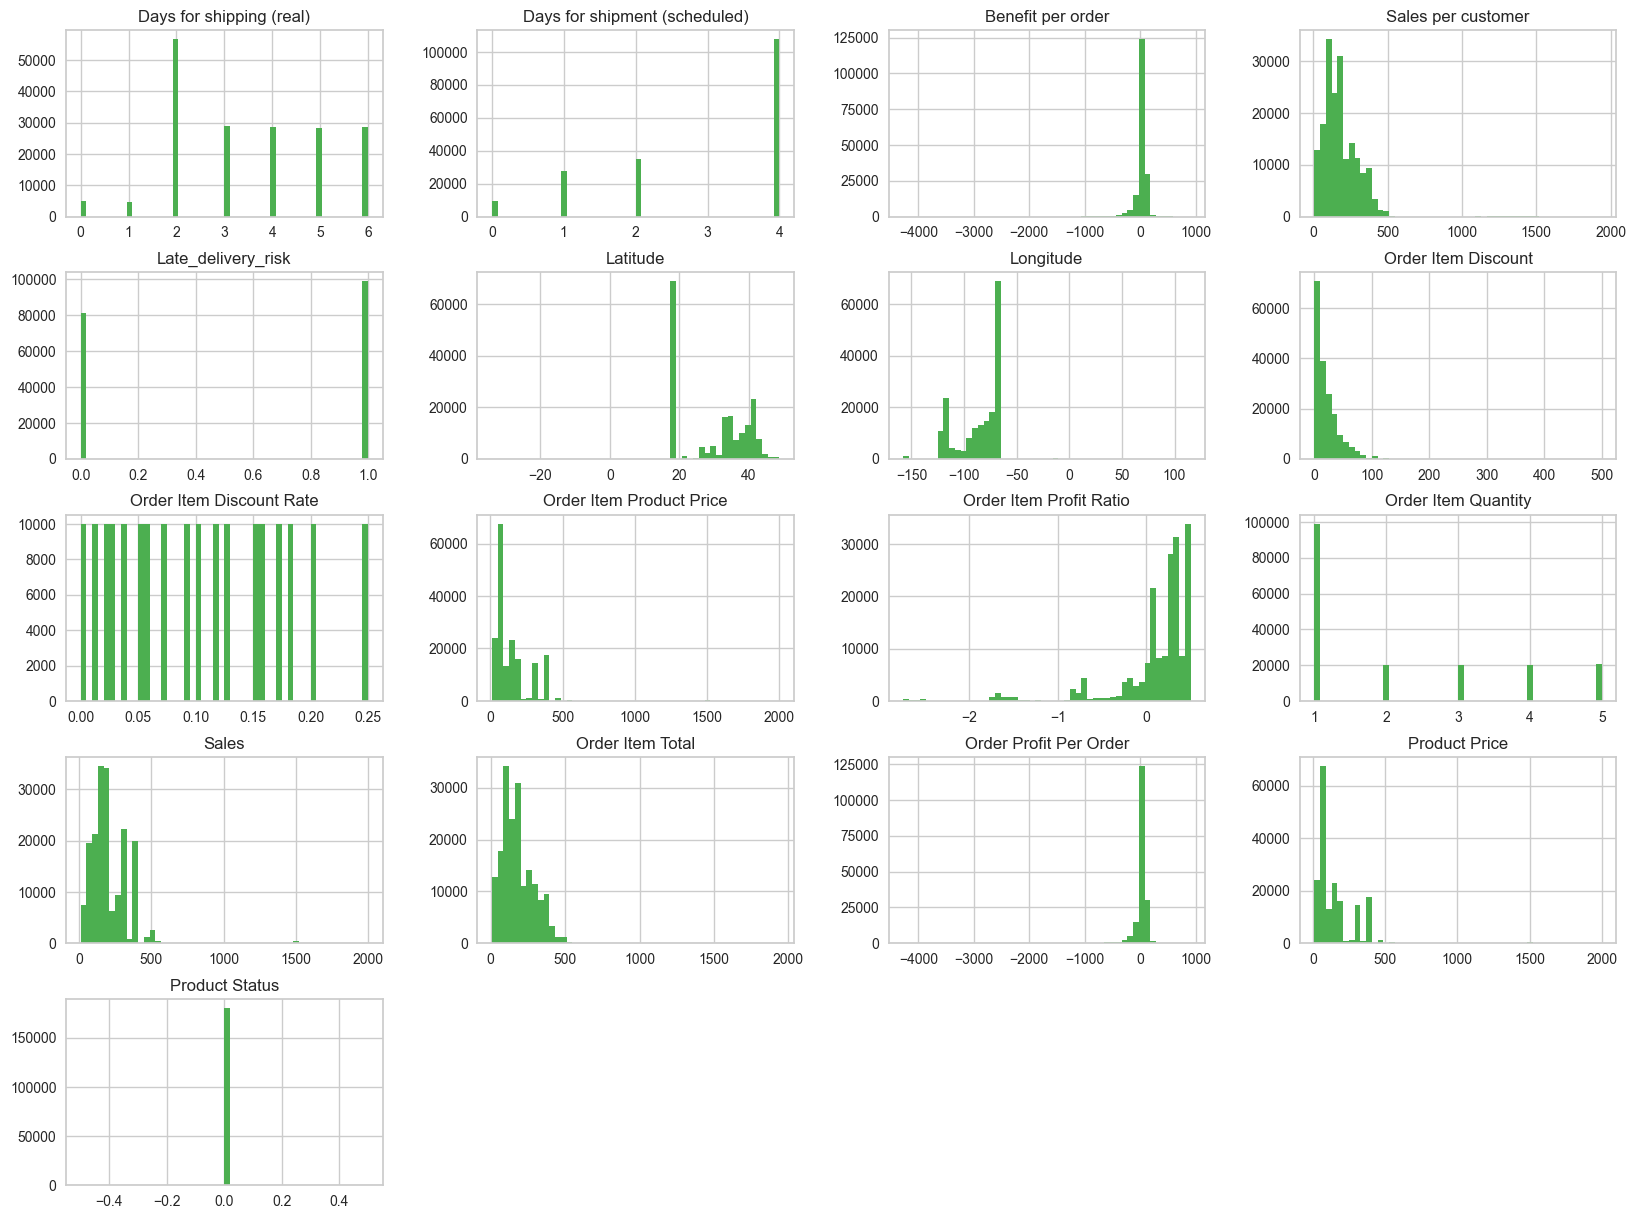

In [15]:
# Visualisation
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Drop columns with data types other than integer or float
df_visualisation = df[numeric_columns.columns]

# Remove the ids from the data as well
df_visualisation.drop(columns=["Category Id", "Customer Id", "Department Id",
                               "Order Customer Id", "Order Id", "Order Item Cardprod Id",
                               "Order Item Id", "Product Card Id", "Product Category Id"],
                               inplace = True)

# Plot the data to get an initial overview
df_visualisation.hist(bins = 50, figsize = (20,15), color='#4CAF50')
plt.show()

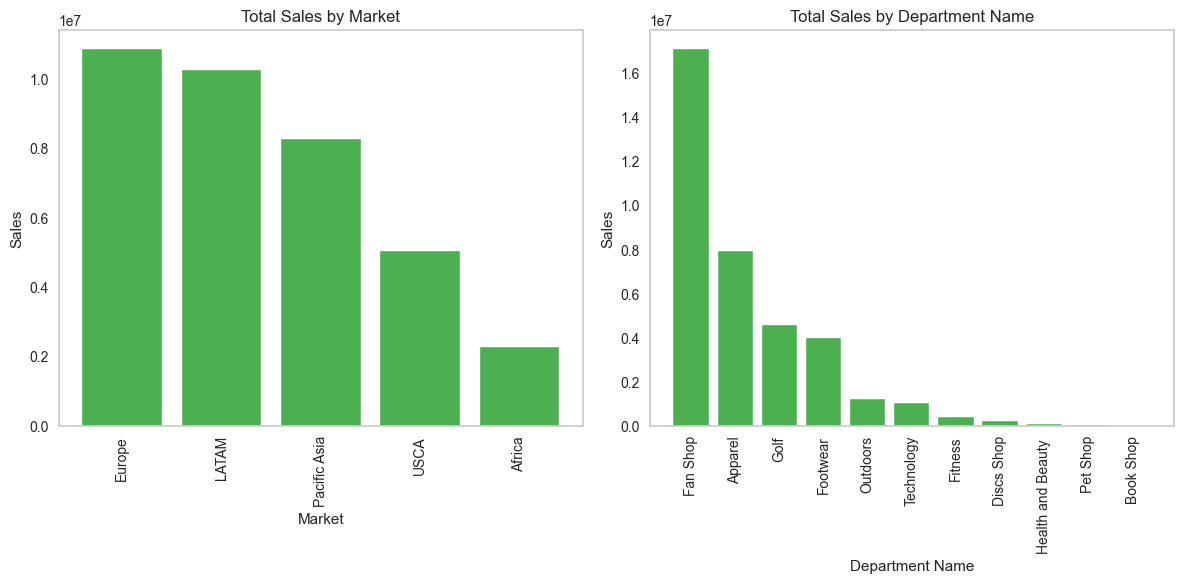

In [34]:
# Aggregate the data by market and sales value
sns.set_style("whitegrid", {'axes.grid' : False})
df_data = df.copy()
sales_market = df_data.groupby("Market").agg({"Sales": "sum"})
# Sort the data frame by highest order volume
sales_market = sales_market.sort_values("Sales", ascending=False)

# Aggregate the data by department and sales value
sales_department = df_data.groupby("Department Name").agg({"Sales": "sum"})
# Sort the data frame by highest order volume
sales_department = sales_department.sort_values("Sales", ascending=False)

data = [(sales_market, "Market"), (sales_department, "Department Name")]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, (df_data, label) in enumerate(data):
    axes[i].bar(df_data.index, df_data["Sales"], color='#4CAF50')
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Sales")
    axes[i].set_title(f"Total Sales by {label}")

    # Rotate x-axis labels by 90 degrees
    axes[i].tick_params(axis='x', rotation=90)

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plots
plt.show()

It is evident that Europe dominates as the primary sales market, indicating a robust performance in that region. Furthermore, the Fan Shop department stands out as the top-performing category, demonstrating its significant popularity and strong sales within the overall product offerings.

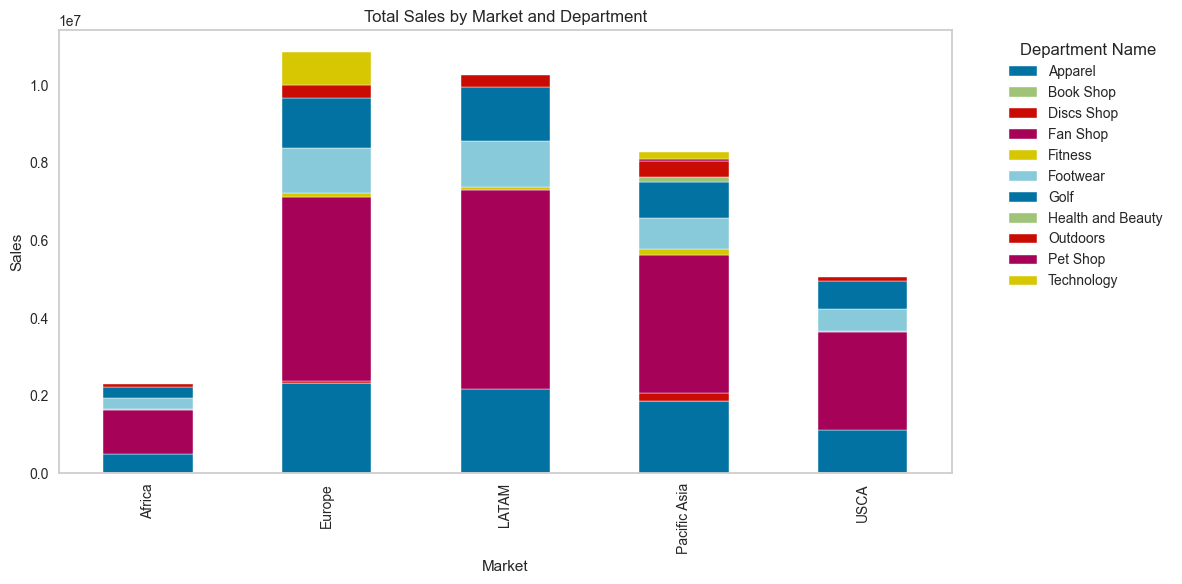

In [35]:
# Aggregate the data by both "Market" and "Department Name"
df_data_2 = df.copy()
sales_market_department = df_data_2.groupby(["Market", "Department Name"]).agg({"Sales": "sum"})
# Sort the data by total sales
sales_market_department = sales_market_department.sort_values("Sales", ascending=False)

# Create a pivot table to reshape the data
pivot_table = sales_market_department.reset_index().pivot(index="Market", columns="Department Name", values="Sales")

# Plot the stacked bar chart
pivot_table.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.xlabel("Market")
plt.ylabel("Sales")
plt.title("Total Sales by Market and Department")
plt.legend(title="Department Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

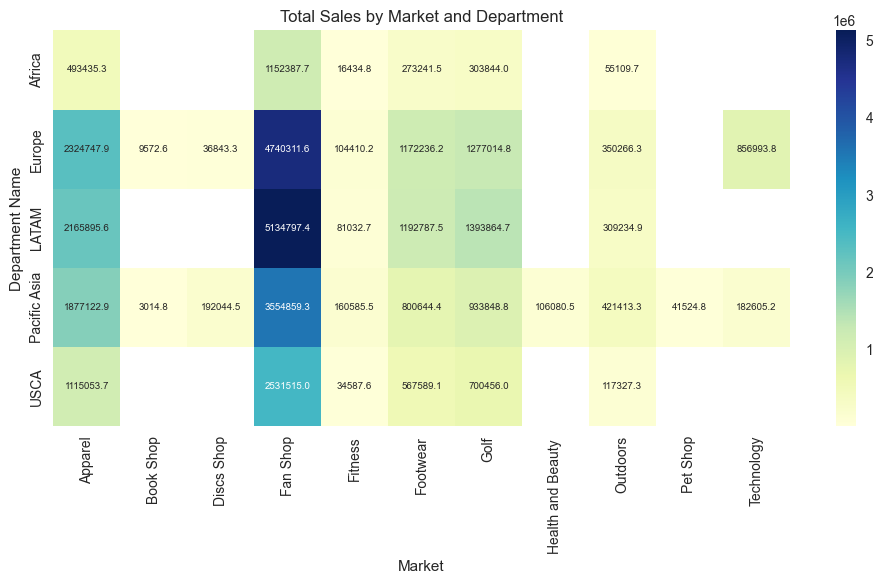

In [36]:
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", annot_kws={"size": 7})
plt.xlabel("Market")
plt.ylabel("Department Name")
plt.title("Total Sales by Market and Department")
plt.tight_layout()
plt.show()

Latin America leads in the sales of Fan Shop items, with notable variations in market preferences. Europe tops the charts for Apparel sales, closely followed by Latin America. Meanwhile, technology department items are primarily sold in Europe and Asia Pacific.

In [19]:
# Interactive map
# Drop duplicate rows based on "Latitude" and "Longitude" columns, keeping the first occurrence
df_unique_locations = df.drop_duplicates(subset=["Latitude", "Longitude"], keep="first")
# Merge the DataFrames based on "Customer City"
df_unique_locations = df_unique_locations.groupby(["Customer City"]).agg({"Sales": "sum"})
# Create dataframe for coordinates
df_coordinaates = df.drop_duplicates(subset="Customer City")
# Perform an inner merge on the common key column ("Customer City")
df_locations = df_unique_locations.merge(df_coordinaates, on="Customer City", how="inner")
df_locations = df_locations[["Customer City", "Latitude", "Longitude", "Sales_x"]]
df_locations.rename(columns={"Sales_x": "Sales"}, inplace=True)
# Set the center of the map
map_center = [df_locations["Latitude"].mean(), df_locations["Longitude"].mean()]
map_plot = folium.Map(location=map_center, zoom_start=10)

# Prepare data for the heatmap: latitude, longitude, and intensity (sales)
heat_data = [[row["Latitude"], row["Longitude"], row["Sales"]] for index, row in df_locations.iterrows()]
plugins.HeatMap(heat_data).add_to(map_plot)
# Display the map
map_plot.save("Sales_Heatmap.html")  # Save as HTML file

In [20]:
!open Sales_Heatmap.html

## Clustering Data

In [40]:
# Create a seperate dataframe for clustering
columns_clustering = ["Product Name", "Order Item Discount", "Order Item Discount Rate", 
                      "Order Item Product Price", "Order Item Profit Ratio", "Order Item Quantity",
                      "Sales", "Order Item Total", "Order Profit Per Order", "Product Price"]
df_clustering = df[columns_clustering]
# Aggregate the data
df_clustering = df_clustering.groupby("Product Name").agg({"Order Item Quantity": "sum",
                                                           "Order Item Discount Rate": "mean",
                                                           "Sales": "sum",
                                                           "Order Item Profit Ratio": "mean"})
# Reset the index to not obtain the product name as an index
df_clustering = df_clustering.reset_index()

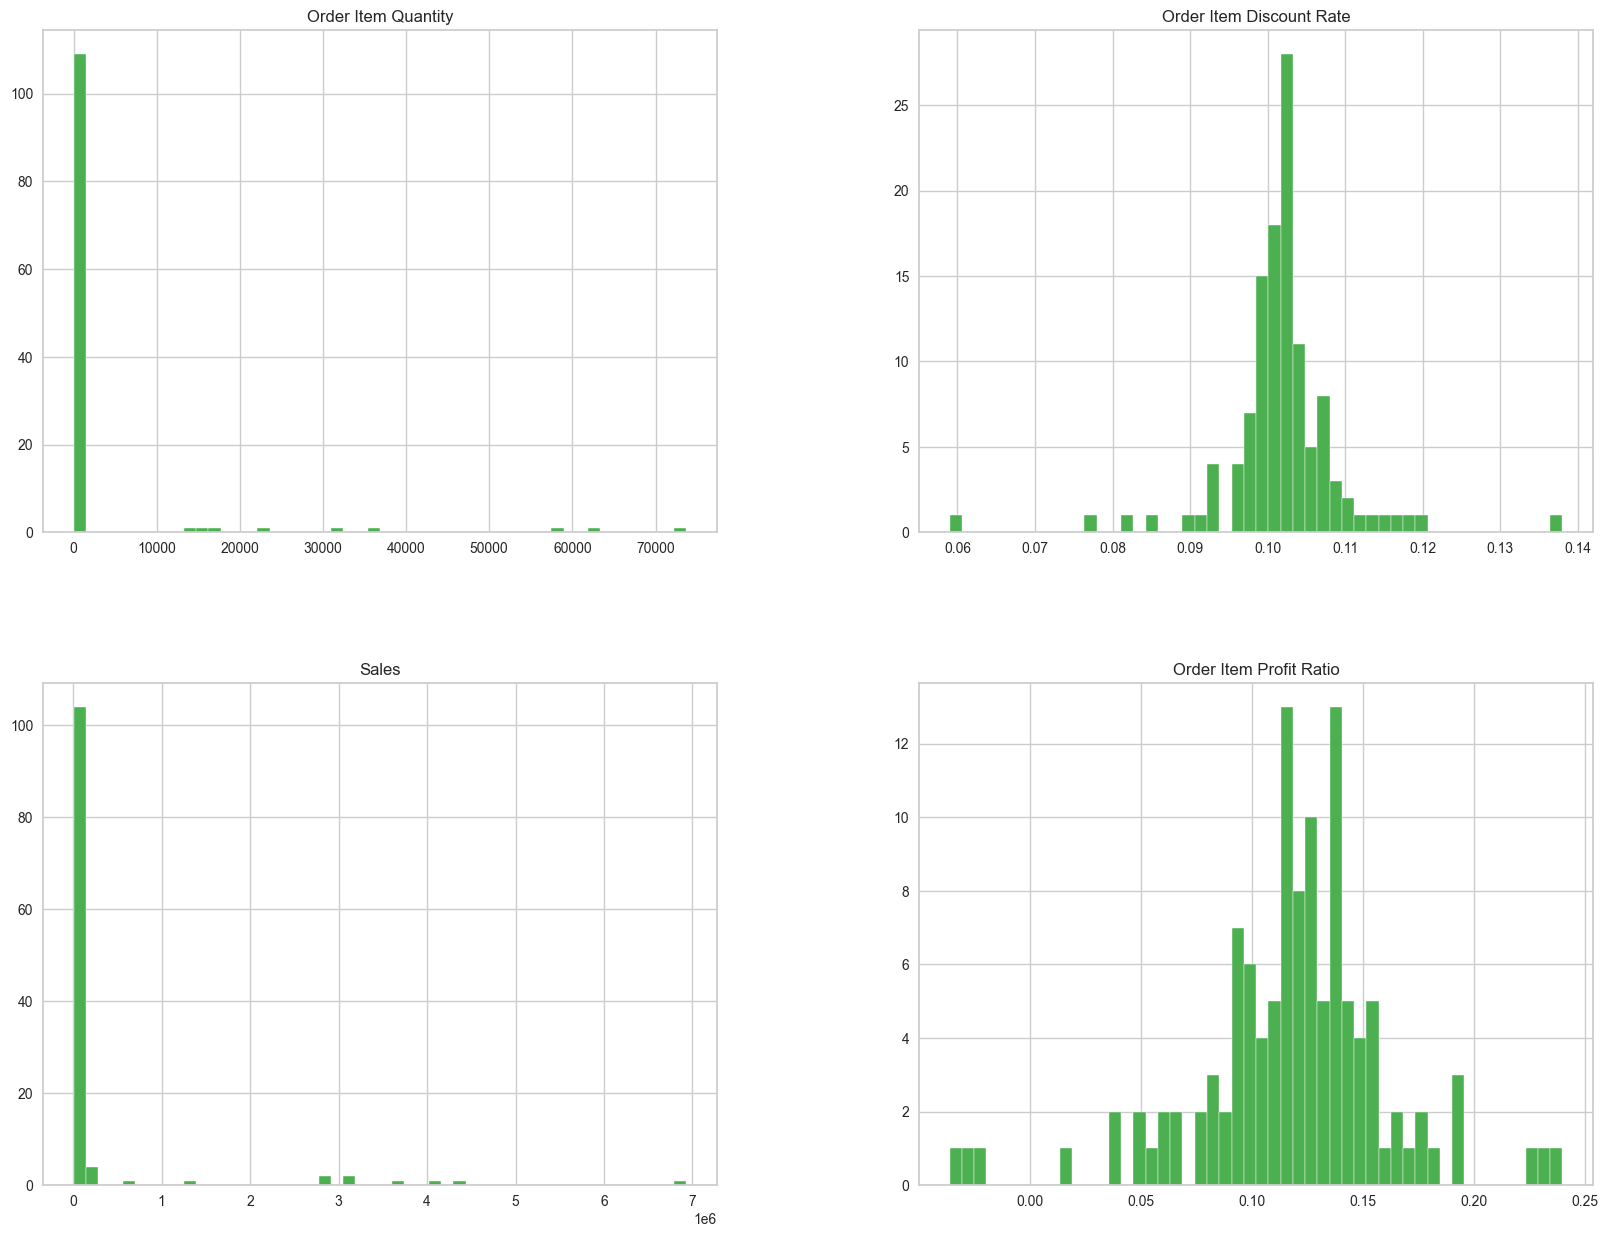

In [42]:
# Plot the data to get an inital overview
df_clustering.hist(bins = 50, figsize = (20,15), color='#4CAF50')
plt.show()

The data from "Order Item Quantity" and "Sales" suggests that a majority of the SKUs experience low sales frequency, while eight SKUs stand out with significantly high sales volumes, representing high-selling products. Similarly, the distribution of discount rates and profit ratios appears to follow a normal distribution pattern. To delve deeper into these insights, a Pareto Chart will be employed for further analysis.
A Pareto chart is a special example of a bar chart. For a Pareto chart, the bars are ordered by frequency counts from highest to lowest. These charts are often used to identify areas to focus on first in process improvement.

--------------------------------------------------------------------------------------------------------------------------------------------
Once more, the issue of survivorship bias is present in our analysis. Regrettably, the available data doesn't provide sufficient information to address this concern. A potential solution could involve generating a comprehensive list of all SKUs in stock. By comparing this list to the sales data, we can identify products that have not been sold at all. These non-selling products could then be strategically relocated to a storage area with lower inventory costs, optimizing inventory management.

--------------------------------------------------------------------------------------------------------------------------------------------

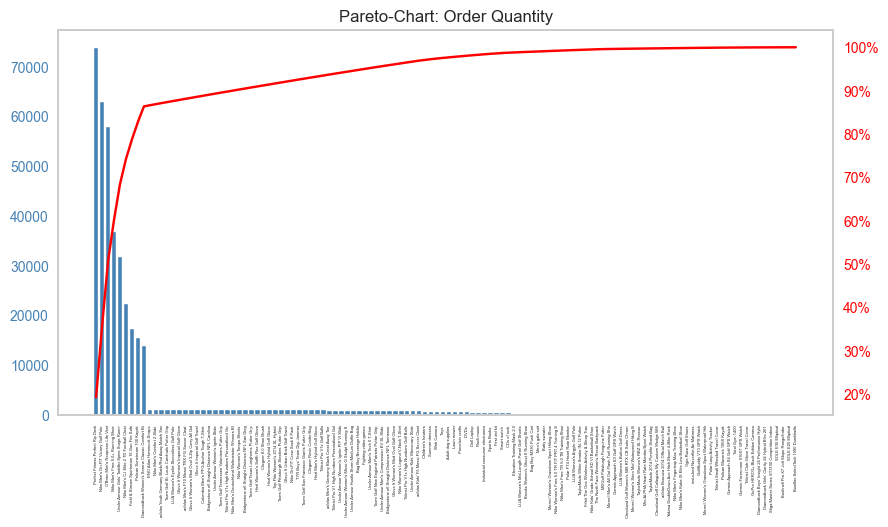

In [43]:
# Sort the dataframe by highest order volume
df_order_qty = df_clustering.sort_values("Order Item Quantity", ascending=False)
# Add column to display the cumulative percentage of the order quantity
df_order_qty["Cumperc Qty"] = df_order_qty["Order Item Quantity"].cumsum()/df_order_qty["Order Item Quantity"].sum()*100

# Define aesthetics for the plot
color1 = 'steelblue'
color2 = 'red'
line_size = 2

# Create basic bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_order_qty["Product Name"], df_order_qty["Order Item Quantity"], color=color1)
ax.set_title("Pareto-Chart: Order Quantity")

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_order_qty["Product Name"], df_order_qty["Cumperc Qty"], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
ax.tick_params(axis='x', rotation=90, labelsize=3) 

# Remove internal grid lines
ax.grid(False)
ax2.grid(False)

# Display Pareto chart
plt.show()

In terms of order quantity, it is clearly visible that nine SKUs out of 118 make up 90% of the total order quantity. We do the same for the sales value.

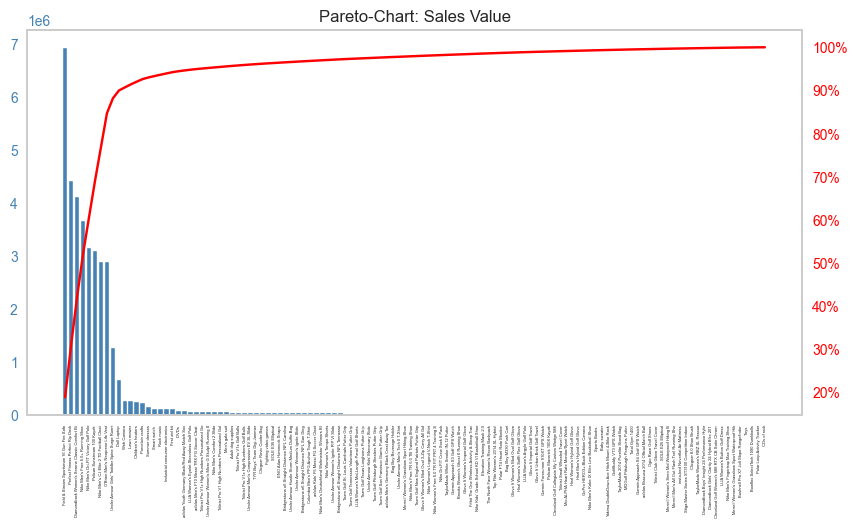

In [44]:
# Sort by Sales
df_sales_value = df_clustering.sort_values("Sales", ascending=False)
#add column to display cumulative percentage
df_sales_value["Cumperc Sales"] = df_sales_value["Sales"].cumsum()/df_sales_value["Sales"].sum()*100

# Create basic bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_sales_value["Product Name"], df_sales_value["Sales"], color=color1)
ax.set_title("Pareto-Chart: Sales Value")

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_sales_value["Product Name"], df_sales_value["Cumperc Sales"], color=color2, ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
ax.tick_params(axis='x', rotation=90, labelsize=3) 

# Remove internal grid lines
ax.grid(False)
ax2.grid(False)

# Display Pareto chart
plt.show()

Also for the sales value the same can be observed. Only nine SKUs contribute to approximately 90% of the overall sales value over the observed period of time. Now the clustering will begin.

### Clustering Methods
Several clustering methods are available. We can distinguish roughly by two categories: 
- an algorithmic approach: Since the items do not have any categories else than the associated department, they are unlabelled. An applicable method, in this case, is an unsupervised learning method. One of the applications within unsupervised learning is clustering, where we want to partition the data into distinct groups of similar item --> k-Means or DBSCAN
- an inventory management approach: An inventory management-based approach to classify SKUs is for example the ABC-Classification. This approach determines the value of SKUs based on their importance for the business. Different variables can be used to classify them, such as sales volume or profitability. Class A would for example consists of the 20% top-selling SKUs generating roughly 70% of the total value. These SKUs require frequent reorders and sufficient stock levels. Class B consists of roughly 30% of the overall SKUs and 25% of the value, while C-SKUs have a value of 5% and consist of 50% of the total SKUs. These numbers are just indications and can vary.
In most cases, ABC-Classification is too narrow, since it only uses one parameter, the value. Another form of classification, XYZ-Classification is often used simultaneously since it is categorizing the SKUs based on the uncertainty of demand. Some SKUs might have high but unstable demand, while others have stable but low demand. The figure below gives an overview of the combination of ABCXYZ-Classification.

![title](ABC.png)

#### PCA and K-Means Clustering Algorithm

In [25]:
# Create dataframe for K-Means
df_kmeans = df_clustering.drop("Product Name", axis=1)
column_names = df_kmeans.columns

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_kmeans)
df_scaled_data = pd.DataFrame(scaled_data)
df_scaled_data.columns = column_names

# In order to reduce the dimensionality of the data from 4 to 2 dimension, PCA is applied to reduce the dataset to two dimensions. 
pca = PCA(n_components=2)
X2D = pca.fit_transform(df_scaled_data)
df_pca = pd.DataFrame(X2D)
df_pca.columns = ["PC1", "PC2"]
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
# Print the total variance explained
print("Total explained variance by two PC's:", round((explained_variance_ratio[0]+explained_variance_ratio[1])*100,2), "%")

Total explained variance by two PC's: 76.29 %


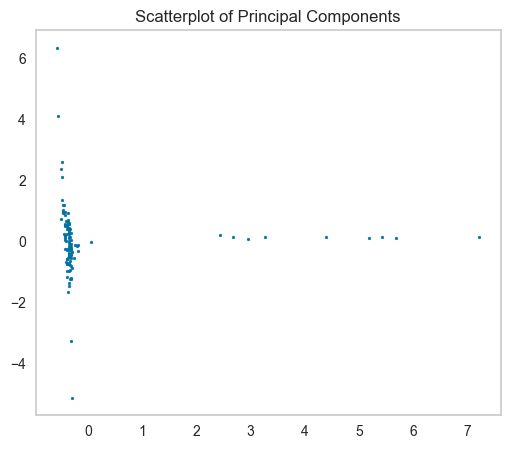

In [45]:
# Create basic Scatter plot of PC's
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df_pca["PC1"], df_pca["PC2"], s=4)
# Remove internal grid lines
ax.grid(False)
ax.set_title("Scatterplot of Principal Components")
plt.show()

By reducing the dataset to two dimensions, we are left with a total explained variance of 76.29 %. That’s not bad, usually a value of above 80% is targeted but as usual this highly depends on the use-case.

In order for the algorithm to work, the number of clusters must be defined beforehand. However, determining the optimal number of clusters can be challenging as it’s not always known in advance. To address this, visual techniques such as scatterplots or others can be used to provide some insights. Two common methods for identifying the appropriate number of clusters are the elbow plot and the silhouette plot. The elbow plot examines the inertia values obtained from running the KMeans algorithm for different cluster numbers, while the silhouette plot calculates silhouette scores. These plots are generated by running the mKMeans algorithm for varying numbers of clusters, typically up to a reasonable limit, such as ten iterations/clusters as we do below.

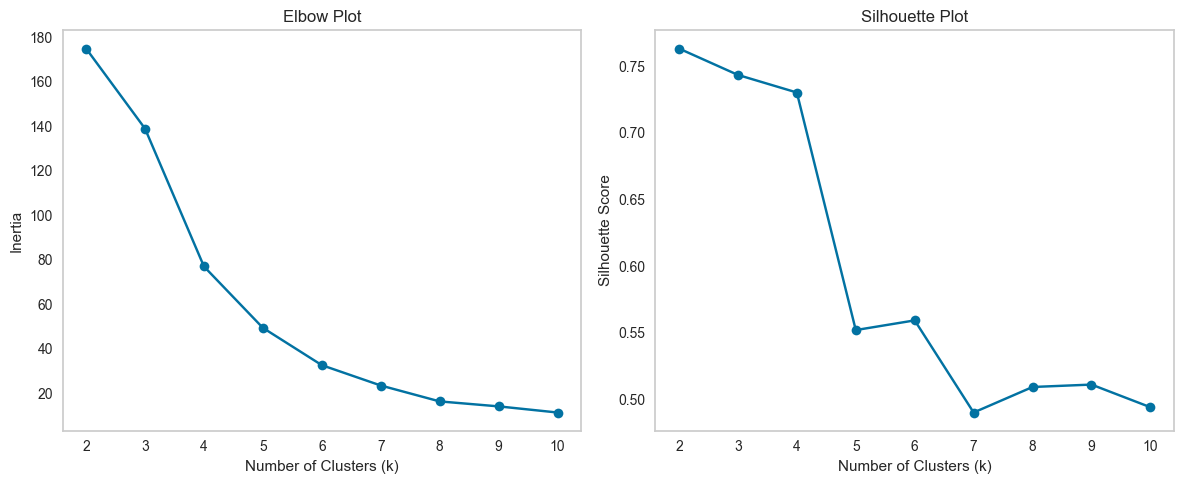

In [46]:
# Create lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# Set a range of k values, for example 1 to 10
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca) 
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_pca, kmeans.labels_))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow plot
axes[0].plot(k_values, inertia, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Plot')

# Silhouette plot
axes[1].plot(k_values, silhouette_scores, marker='o')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Plot')

# Adjust spacing between the plots
plt.tight_layout()

for ax in axes:
    ax.grid(False)

# Display the plots
plt.show()

The elbow plot illustrates the inertia (sum of squared distances from data points to their assigned cluster centroids) as a function of the number of clusters (k). When examining the plot, we observe that the inertia decreases rapidly and consistently as we increase the number of clusters. The elbow plot serves as a rough visual guide to determine the suitable number of clusters. However, from the above plot, it is challenging to precisely identify an optimal value for k. To gain more insights, we also create the silhouette plot. Silhouette scores range from -1 to +1, providing information about the quality of the clustering. A coefficient close to +1 indicates that the data point is well within its own cluster and distant from other clusters. A coefficient close to 0 suggests that the data point is near a cluster boundary. Conversely, a coefficient of -1 indicates that the data point might have been assigned to the wrong cluster (Source: ‘Praxiseinstieg Machine Learning mit Scikit-Learn, Keras und Tensorflow’, p.249). Consequently, higher silhouette scores indicate better clustering.
Based on the above silhouette plot, it appears that two clusters would be the most suitable choice. To validate this, we will compute the K-Means algorithm with two clusters and visualize the resulting clusters.

In [28]:
# We have chosen two clusters so we run K-Means with number of clusters equals two
kmeans_pca = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
# Fit the data with the k-means pca model
kmeans_pca.fit(df_pca)

KMeans(n_clusters=2, random_state=42)

In [29]:
# Create new data frame with the original features and add the PCA scores and assigned clusters
df_pca_kmeans = pd.concat([df_kmeans.reset_index(drop = True), pd.DataFrame(df_pca)], axis = 1)
df_pca_kmeans.columns.values[-2: ] = ["Component 1", "Component 2"]
# The last column we add contains the pca k-means clustering labels
df_pca_kmeans["Segment K-Means PCA"] = kmeans_pca.labels_
# We create a new column named ‘Segment’ and map the two clusters directly inside it.
df_pca_kmeans["Segment"] = df_pca_kmeans["Segment K-Means PCA"].map({0:"first",
                                                                     1:"second"})

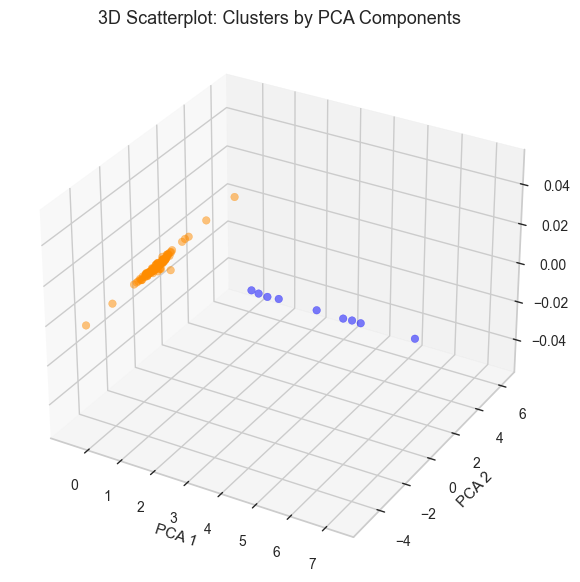

In [30]:
# Create 3D-Scatterplot of PCA
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

colors = {"first": "darkorange", "second": "blue"}

ax.scatter(df_pca_kmeans["Component 1"],
           df_pca_kmeans["Component 2"],
           c = df_pca_kmeans['Segment'].map(colors),
           marker='o', s = 30, alpha=0.5)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.title("3D Scatterplot: Clusters by PCA Components", size = 13)
plt.show()

One can clearly see that most of the data points are marked with orange color, only 9 SKU’s are in the other (blue) cluster and 109 out of 118 SKU’s are classified within the orange cluster. These 9 SKUs are most likely the ones with high sales and quantity. The differences are getting visualized below.

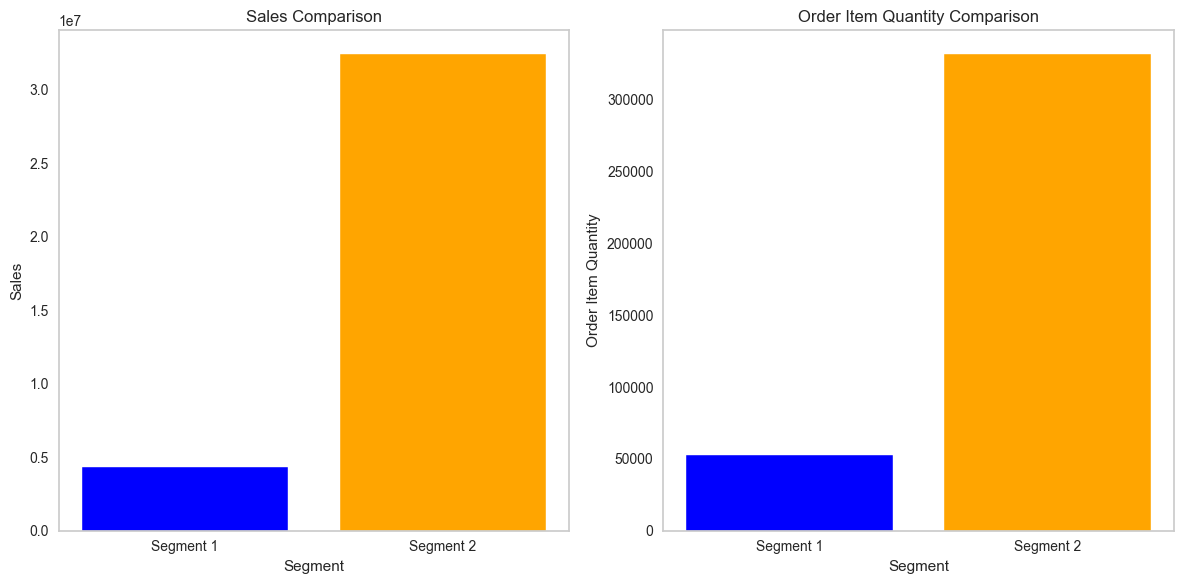

In [47]:
# Aggregate the cluster with their respective mean values for the variables
df_pca_kmeans_aggregated = df_pca_kmeans.groupby("Segment").aggregate({"Order Item Quantity" : "sum",
                                                                       "Sales" : "sum"})
# Extract data for Segment 1 and Segment 2
segment1_data = df_pca_kmeans_aggregated.loc["first"]
segment2_data = df_pca_kmeans_aggregated.loc["second"]

# Extract sales and order item quantity values
sales_segment1 = segment1_data["Sales"]
sales_segment2 = segment2_data["Sales"]

order_item_quantity_segment1 = segment1_data["Order Item Quantity"]
order_item_quantity_segment2 = segment2_data["Order Item Quantity"]

# Create two separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for Sales
ax1.bar(["Segment 1", "Segment 2"], [sales_segment1, sales_segment2], color=['blue', 'orange'])
ax1.set_title("Sales Comparison")
ax1.set_ylabel("Sales")
ax1.set_xlabel("Segment")
ax1.grid(axis="y")

# Bar chart for Order Item Quantity
ax2.bar(["Segment 1", "Segment 2"], [order_item_quantity_segment1, order_item_quantity_segment2], color=['blue', 'orange'])
ax2.set_title("Order Item Quantity Comparison")
ax2.set_ylabel("Order Item Quantity")
ax2.set_xlabel("Segment")
ax2.grid(axis="y")

ax1.grid(False)
ax2.grid(False)


plt.tight_layout()
plt.show()

Yes, it is clearly visible that the two defined clusters strongly deviate in Sales and Order Item Quantity (volume), as assumed. So far we completed the algorithmic approach of clustering the SKU’s. Instead of two clusters, one could also try three clusters. The silhouette score is also high for three clusters and the elbow plot is rather difficult to assess.

#### ABC Classification

We assume: SKUs covering sales up to 70% of the total sales are considered A-SKUs, between 70% and 95% are B-SKUs and the rest are C-SKU’s (Inspiration: RFM and ABC Analysis on Data Co Supply Chain Data | Kaggle)

In [32]:
# Sort values by highest to lowest sales
df_abc = df_clustering[["Product Name", "Sales"]].sort_values(by="Sales",ascending=False).reset_index()
# Add cumulative sum of the sales as a new column
df_abc["cum_sum"] = df_abc["Sales"].cumsum()
# Add the cumulated percentage of the sales as a new column
df_abc["cum_per"] = df_abc["cum_sum"]/df_abc["Sales"].sum()*100
# Add the percentage of each SKU as a new column
df_abc["per"] = df_abc["cum_per"]-df_abc["cum_per"].shift(1)
# Add the first missing value in column "per" to be the first of cumulative percentage
df_abc.loc[0,"per"] = df_abc["cum_per"][0]
# Drop the second index column
df_abc.drop(columns="index", inplace=True)
# Define function to classify the SKUs based on their cumlated percentage revenue
def abc_classification(data):
    if data["cum_per"]<=70:
        return "A"
    elif data["cum_per"]>70 and data["cum_per"]<=95:
        return "B"
    elif data["cum_per"]>95:
        return "C"

# Apply the function to the data and add a new column for the classification
df_abc["Category"] = df_abc.apply(abc_classification, axis=1)

# Create a variable to visualise the data
abc_graph = df_abc[["Category","Product Name","Sales"]].groupby("Category").agg(Revenue=("Sales","sum"),count=("Product Name","count"))

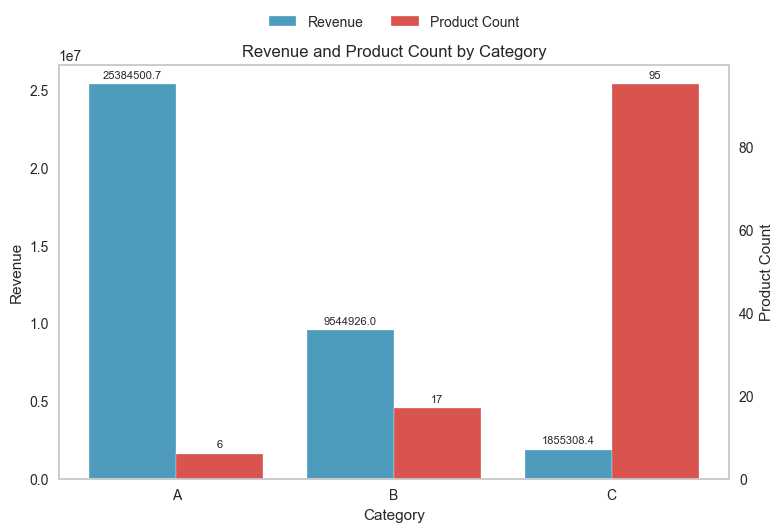

In [48]:
# Extract data for plotting
categories = abc_graph.index
revenue = abc_graph["Revenue"]
product_count = abc_graph["count"]

# Calculate the width for each bar group
bar_width = 0.4
index = list(range(len(categories)))
offset = 0.2

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot revenue bars on the left axis
bars1 = ax1.bar([i - offset for i in index], revenue, bar_width, label='Revenue', alpha=0.7, color='b')
ax1.set_ylabel("Revenue")
ax1.set_xlabel("Category")
ax1.set_xticks(index)
ax1.set_xticklabels(categories)

# Create a twin axes on the right side
ax2 = ax1.twinx()

# Plot product count bars on the right axis
bars2 = ax2.bar([i + offset for i in index], product_count, bar_width, label='Product Count', alpha=0.7, color='r')
ax2.set_ylabel("Product Count")

# Show legend for both axes in the top-middle position
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Function to label the bars with sales values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax1.annotate('{:.1f}'.format(height),  # Format sales as a float with one decimal place
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)  # Set the font size for the sales labels

# Label the revenue bars with sales values
autolabel(bars1)

# Function to label the product count bars with their values
def autolabel_product_count(bars):
    for bar in bars:
        height = bar.get_height()
        ax2.annotate('{}'.format(int(height)),  # Format product count as an integer
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)  # Set the font size for the product count labels

# Label the product count bars with their values
autolabel_product_count(bars2)

ax1.grid(False)
ax2.grid(False)

plt.title("Revenue and Product Count by Category")
plt.tight_layout()
plt.show()

The bar chart is revealing the classification metrics: Only six SKU’s make up 70% of our total sales, whereas 95 SKU’s contribute only 5% of total sales.

#### Conclusion
We employed two distinct methods to categorize SKUs based on their characteristics. The choice between these approaches depends on the specific business needs. In our current dataset, the traditional ABC-Classification stands out as more suitable and easier to understand. However, if more features were accessible, an algorithmic approach might become more fitting, contingent on specific business requirements.

For A-SKUs (high-priority items), maintaining ample stock is paramount. Ensuring a sufficient safety stock is crucial to accommodate potential demand fluctuations and uphold a high service level, guaranteeing consistent availability for customers. A detailed analysis could pinpoint markets with high demand for these A-SKUs, potentially leading to efficient storage and distribution strategies, such as utilizing existing warehouse space or considering rental options. Similar considerations may benefit certain B or C-SKUs. Additionally, when dealing with A-SKUs, careful supplier assessment is advisable to mitigate risks associated with relying solely on one supplier. Diversifying suppliers enhances stability in the supply chain, reducing potential disruptions caused by supplier-related issues.